In [91]:
from paddleocr import PaddleOCR
from pydantic import BaseModel
import cv2
import numpy as np


# # Initialize the OCR model; use GPU if available
# ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang='en')  # Use lang='ch' for Chinese, etc.

# # Specify the image path
# image_path = 'data/images/berserk.png'  # Replace with your image path

# # Perform OCR on the image
# result = ocr.ocr(image_path, cls=True)

# # Print the result
# for line in result:
#     for word_info in line:
#         print(f'Text: {word_info[1][0]}, Confidence: {word_info[1][1]}')

class OCR_Response(BaseModel):
    boxes: list
    texts: list




class OCR:
    def __init__(self):
        self.ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang='en')  
    

    def get_ocr(self, image_path: str):
        """
        Performs OCR on the given image.

        Args:
            image_path (str): The path to the image.

        Returns:
            OCR_Response: An OCR_Response object containing the bounding boxes and texts.
        """
        result = self.ocr.ocr(image_path, cls=True)
        boxes = []
        texts = []
        for line in result:
            for word_info in line:
                boxes.append(word_info[0])
                texts.append(word_info[1][0])
        return OCR_Response(boxes=boxes, texts=texts)
    

ocr = OCR()
response = ocr.get_ocr('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/36.jpg')

# Load the image
image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/36.jpg')

# Draw boxes around the text data
for text, box in zip(response.texts, response.boxes):
    print(f'Text: {text}, Box: {box}')
    box = [tuple(map(int, point)) for point in box]
    cv2.polylines(image, [np.array(box)], isClosed=True, color=(0, 255, 0), thickness=2)
    # Write the image with boxes to a file

[2024/10/19 14:58:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/akxy4321/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/akxy4321/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_tex

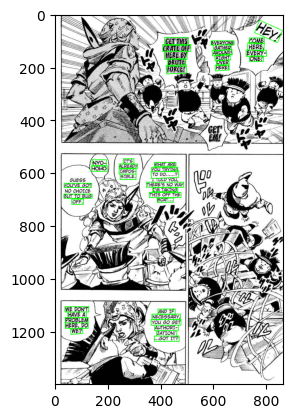

In [92]:
plt.imshow(image)

In [117]:
# def intersecting_boxes(box1, box2):
#     print("Merging boxes : ", box1, box2)
#     """
#     Checks if two boxes intersect.

#     Args:
#         box1 (list): The first box.
#         box2 (list): The second box.

#     Returns:
#         bool: True if the boxes intersect, False otherwise.
#     """


#     acord1, acord2, acord3, acord4 = box1
#     bcord1, bcord2, bcord3, bcord4 = box2

#     box_1_y_average = (acord1[1] + acord2[1] + acord3[1] + acord4[1]) / 4
#     box_2_y_average = (bcord1[1] + bcord2[1] + bcord3[1] + bcord4[1]) / 4

#     box_1_x_average = (acord1[0] + acord2[0] + acord3[0] + acord4[0]) / 4
#     box_2_x_average = (bcord1[0] + bcord2[0] + bcord3[0] + bcord4[0]) / 4



#     if(abs(box_1_y_average - box_2_y_average) > 3 and abs(box_1_x_average - box_2_x_average) > 3):
#         return False
#     else:
#         return True

def do_edges_intersect(p1, p2, q1, q2):
    """
    Check if two edges (p1-p2 and q1-q2) intersect or touch.

    Args:
        p1, p2 (tuple): Endpoints of the first edge.
        q1, q2 (tuple): Endpoints of the second edge.

    Returns:
        bool: True if the edges intersect or touch, False otherwise.
    """
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    def on_segment(p, q, r):
        if min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and min(p[1], r[1]) <= q[1] <= max(p[1], r[1]):
            return True
        return False

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, q1, p2):
        return True

    if o2 == 0 and on_segment(p1, q2, p2):
        return True

    if o3 == 0 and on_segment(q1, p1, q2):
        return True

    if o4 == 0 and on_segment(q1, p2, q2):
        return True

    return False

def intersecting_polygons(poly1, poly2):
    """
    Check if two polygons intersect or touch.

    Args:
        poly1 (list): Coordinates of the first polygon [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
        poly2 (list): Coordinates of the second polygon [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].

    Returns:
        bool: True if the polygons intersect or touch, False otherwise.
    """
    for i in range(len(poly1)):
        for j in range(len(poly2)):
            if do_edges_intersect(poly1[i], poly1[(i + 1) % len(poly1)], poly2[j], poly2[(j + 1) % len(poly2)]):
                return True
    return False


# def intersecting_boxes(box1, box2, threshold=0):
#     """
#     Check if two boxes intersect with a given threshold.

#     Args:
#         box1 (list): Coordinates of the first box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
#         box2 (list): Coordinates of the second box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
#         threshold (float): Distance threshold for considering boxes as intersecting.

#     Returns:
#         bool: True if the boxes intersect within the threshold, False otherwise.
#     """
    
#     x1_coords = [point[0] for point in box1]
#     x2_coords = [point[0] for point in box2]
#     y1_coords = [point[1] for point in box1]
#     y2_coords = [point[1] for point in box2]


#     # Extract the coordinates of the boxes
#     x1_min, y1_min = min(x1_coords), min(y1_coords)
#     x1_max, y1_max = max(x1_coords), max(y1_coords)

#     x2_min, y2_min = min(x2_coords), min(y2_coords)
#     x2_max, y2_max = max(x2_coords), max(y2_coords)


#     return True

# def intersecting_boxes(box1, box2, threshold=15):
#     """
#     Check if two boxes intersect with a given threshold.

#     Args:
#         box1 (list): Coordinates of the first box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
#         box2 (list): Coordinates of the second box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
#         threshold (float): Distance threshold for considering boxes as intersecting.

#     Returns:
#         bool: True if the boxes intersect within the threshold, False otherwise.
#     """
    
#     # Extract x and y coordinates for both boxes
#     x1_coords = [point[0] for point in box1]
#     x2_coords = [point[0] for point in box2]
#     y1_coords = [point[1] for point in box1]
#     y2_coords = [point[1] for point in box2]

#     # Determine the bounding box for both sets of coordinates
#     x1_min, y1_min = min(x1_coords), min(y1_coords)
#     x1_max, y1_max = max(x1_coords), max(y1_coords)

#     x2_min, y2_min = min(x2_coords), min(y2_coords)
#     x2_max, y2_max = max(x2_coords), max(y2_coords)

#     # Check if the boxes intersect by comparing their ranges
#     x_overlap = not (x1_max + threshold < x2_min or x2_max + threshold < x1_min)
#     y_overlap = not (y1_max + threshold < y2_min or y2_max + threshold < y1_min)

#     # Return True if both x and y ranges overlap
#     return x_overlap and y_overlap

def intersecting_boxes(box1, box2, threshold=15):
    """
    Check if two boxes intersect with a given threshold, considering both expansion (+threshold)
    and contraction (-threshold).

    Args:
        box1 (list): Coordinates of the first box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
        box2 (list): Coordinates of the second box [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
        threshold (float): Distance threshold for considering boxes as intersecting.

    Returns:
        bool: True if the boxes intersect within the threshold, False otherwise.
    """
    
    # Extract x and y coordinates for both boxes
    x1_coords = [point[0] for point in box1]
    x2_coords = [point[0] for point in box2]
    y1_coords = [point[1] for point in box1]
    y2_coords = [point[1] for point in box2]

    # Determine the bounding box for both sets of coordinates
    x1_min, y1_min = min(x1_coords), min(y1_coords)
    x1_max, y1_max = max(x1_coords), max(y1_coords)

    x2_min, y2_min = min(x2_coords), min(y2_coords)
    x2_max, y2_max = max(x2_coords), max(y2_coords)

    # Check if the boxes intersect considering both expansion (+threshold) and contraction (-threshold)
    
    # For x-coordinates
    x_overlap_expanded = not (x1_max + threshold < x2_min or x2_max + threshold < x1_min)
    x_overlap_contracted = not (x1_max - threshold < x2_min or x2_max - threshold < x1_min)
    
    # For y-coordinates
    y_overlap_expanded = not (y1_max + threshold < y2_min or y2_max + threshold < y1_min)
    y_overlap_contracted = not (y1_max - threshold < y2_min or y2_max - threshold < y1_min)

    # Return True if either expanded or contracted ranges overlap in both x and y coordinates
    return (x_overlap_expanded and y_overlap_expanded) or (x_overlap_contracted and y_overlap_contracted)





def merge_boxes(box1, box2):
    """
    Merges two boxes.

    Args:
        box1 (list): The first box.
        box2 (list): The second box.

    Returns:
        list: The merged box.
    """

    x_coords = [point[0] for point in box1+box2]
    y_coords = [point[1] for point in box1+box2]

    x1 = min(x_coords)
    x2 = max(x_coords)
    y1 = min(y_coords)
    y2 = max(y_coords)

    return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

def merge_intersecting_boxes(super_boxes):
    """
    Merges intersecting boxes.

    Args:
        boxes (list): A list of boxes.

    Returns:
        list: A list of merged boxes.
    """
    merged_super_boxes = []
    for super_box in super_boxes:
        box, text = super_box
        if not merged_super_boxes:
            merged_super_boxes.append(super_box)
        else:
            intersecting = False
            for i, merged_super_box in enumerate(merged_super_boxes):
                merged_box, merged_text = merged_super_box
                if intersecting_boxes(merged_box, box):

                    new_super_box = (merge_boxes(merged_box, box), merged_text + " " + text)

                    merged_super_boxes[i] = new_super_box
                    intersecting = True
                    break
            if not intersecting:
                merged_super_boxes.append(super_box)
    return merged_super_boxes

super_boxes = list(zip(response.boxes, response.texts))
super_boxes.sort(key=lambda super_box:super_box[0][1], reverse=True)
merged_boxes = merge_intersecting_boxes(super_boxes)
merged_boxes = merge_intersecting_boxes(merged_boxes)
merged_boxes = merge_intersecting_boxes(merged_boxes)
merged_boxes = merge_intersecting_boxes(merged_boxes)
print(merged_boxes)

[([(722.0, 23.0), (860.0, 23.0), (860.0, 179.0), (722.0, 179.0)], 'HEY! HERE, COME EVERY- ONE!'), ([(590.0, 101.0), (677.0, 101.0), (677.0, 215.0), (590.0, 215.0)], 'EVERYONE GATHER RIGHT OVER HERE! AROUND!'), ([(407.0, 88.0), (513.0, 88.0), (513.0, 226.0), (407.0, 226.0)], 'CRATEOFF GETTHIS HEREBY BRUTE FORCE!'), ([(345.0, 561.0), (486.0, 561.0), (486.0, 712.0), (345.0, 712.0)], "THERE'S NO WAY TO DO..... I'M TAKING YOU TRYING WHAT ARE THIS OFF THE BOAT..."), ([(363.0, 1116.0), (476.0, 1116.0), (476.0, 1238.0), (363.0, 1238.0)], 'YOU GOGET NECESSARY, AUTHORI- ZATION! AND IF ..GOTIT?'), ([(242.0, 547.0), (312.0, 547.0), (312.0, 626.0), (242.0, 626.0)], "ALREADY IMPOS- IT'S SIBLE."), ([(138.0, 551.0), (197.0, 551.0), (197.0, 595.0), (138.0, 595.0)], 'HOHO NYO-'), ([(33.0, 681.0), (140.0, 681.0), (140.0, 720.0), (33.0, 720.0)], 'BUT TO BUG OFF.'), ([[34.0, 640.0], [138.0, 640.0], [138.0, 656.0], [34.0, 656.0]], "YOU'VEGOT"), ([(37.0, 1107.0), (127.0, 1107.0), (127.0, 1212.0), (37.0, 1212

In [118]:
merged_boxes

[([(722.0, 23.0), (860.0, 23.0), (860.0, 179.0), (722.0, 179.0)],
  'HEY! HERE, COME EVERY- ONE!'),
 ([(590.0, 101.0), (677.0, 101.0), (677.0, 215.0), (590.0, 215.0)],
  'EVERYONE GATHER RIGHT OVER HERE! AROUND!'),
 ([(407.0, 88.0), (513.0, 88.0), (513.0, 226.0), (407.0, 226.0)],
  'CRATEOFF GETTHIS HEREBY BRUTE FORCE!'),
 ([(345.0, 561.0), (486.0, 561.0), (486.0, 712.0), (345.0, 712.0)],
  "THERE'S NO WAY TO DO..... I'M TAKING YOU TRYING WHAT ARE THIS OFF THE BOAT..."),
 ([(363.0, 1116.0), (476.0, 1116.0), (476.0, 1238.0), (363.0, 1238.0)],
  'YOU GOGET NECESSARY, AUTHORI- ZATION! AND IF ..GOTIT?'),
 ([(242.0, 547.0), (312.0, 547.0), (312.0, 626.0), (242.0, 626.0)],
  "ALREADY IMPOS- IT'S SIBLE."),
 ([(138.0, 551.0), (197.0, 551.0), (197.0, 595.0), (138.0, 595.0)],
  'HOHO NYO-'),
 ([(33.0, 681.0), (140.0, 681.0), (140.0, 720.0), (33.0, 720.0)],
  'BUT TO BUG OFF.'),
 ([[34.0, 640.0], [138.0, 640.0], [138.0, 656.0], [34.0, 656.0]], "YOU'VEGOT"),
 ([(37.0, 1107.0), (127.0, 1107.0), (12

[(722.0, 23.0), (860.0, 23.0), (860.0, 179.0), (722.0, 179.0)]
[(590.0, 101.0), (677.0, 101.0), (677.0, 215.0), (590.0, 215.0)]
[(407.0, 88.0), (513.0, 88.0), (513.0, 226.0), (407.0, 226.0)]
[(345.0, 561.0), (486.0, 561.0), (486.0, 712.0), (345.0, 712.0)]
[(363.0, 1116.0), (476.0, 1116.0), (476.0, 1238.0), (363.0, 1238.0)]
[(242.0, 547.0), (312.0, 547.0), (312.0, 626.0), (242.0, 626.0)]
[(138.0, 551.0), (197.0, 551.0), (197.0, 595.0), (138.0, 595.0)]
[(33.0, 681.0), (140.0, 681.0), (140.0, 720.0), (33.0, 720.0)]
[[34.0, 640.0], [138.0, 640.0], [138.0, 656.0], [34.0, 656.0]]
[(37.0, 1107.0), (127.0, 1107.0), (127.0, 1212.0), (37.0, 1212.0)]


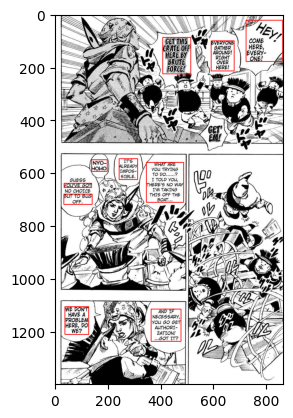

In [119]:
# Loop through each box and draw it on the image


image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/36.jpg')
for box,text in merged_boxes:
    a, b, c, d = box  # Unpacking the box coordinates
    ycoords = [a[1], b[1], c[1], d[1]]  # Y-coordinates of the box corners
    xcoords = [a[0], b[0], c[0], d[0]]  # X-coordinates of the box corners

    # Calculate the width and height of the bounding box
    width = max(xcoords) - min(xcoords)
    height = max(ycoords) - min(ycoords)

    # Skip boxes with zero width or height
    if width <= 0 or height <= 0:
        continue

    print(box)  # Optional: print the box coordinates for debugging
    # Draw the rectangle on the image
    cv2.rectangle(image, (int(min(xcoords)), int(min(ycoords))), 
                    (int(max(xcoords)), int(max(ycoords))), 
                    (255, 0, 0), 2)  # Green boxes with thickness 2

import matplotlib.pyplot as plt
plt.imshow(image)

In [120]:
for super_box in merged_boxes:
    box, text = super_box
    if text.startswith("EVERY") or text.startswith('HEY'):
        print(super_box)

([(722.0, 23.0), (860.0, 23.0), (860.0, 179.0), (722.0, 179.0)], 'HEY! HERE, COME EVERY- ONE!')
([(590.0, 101.0), (677.0, 101.0), (677.0, 215.0), (590.0, 215.0)], 'EVERYONE GATHER RIGHT OVER HERE! AROUND!')


In [121]:
intersecting_boxes([(727.0, 23.0), (860.0, 23.0), (860.0, 139.0), (727.0, 139.0)], [(722.0, 136.0), (799.0, 136.0), (799.0, 179.0), (722.0, 179.0)])

True